In [2]:
import os
import json
import sys
import numpy as np
import random
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.inputs import Poscar
from ase.db import connect
from ase.io import write
from ase.visualize import view

sys.path.append('../Modules')
from structure_generation import * 
from vasp_misc import *


# Composition Selection

## functions

In [3]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def load_compositions(json_file):
    """Load compositions from a JSON file."""
    with open(json_file) as f:
        compositions = json.load(f)
    df = pd.DataFrame(compositions)
    if 'Generation' not in df.columns:
        df['Generation'] = 0
    return df

def filter_compositions(df):
    """Filter compositions to ensure they meet the initial constraints."""
    #return df[(df['V'] >= 0.8) & 
    return df[(df['V'] >= 0.20) &
              (df['Cr'] >= 0.001) & 
              (df['Ti'] >= 0.001) & 
              (df['W'] >= 0.001) & 
              (df['Zr'] >= 0.001)]

def generate_random_composition():
    """Generate a valid random composition within the specified constraints."""
    #min_v = 0.85
    min_v = 0.2
    #changed for hea version
    while True:
        V = np.random.uniform(min_v, 1)
        #Cr = np.random.uniform(0.001, 0.2)
        Cr = np.random.uniform(0.01, 0.2)
        #Ti = np.random.uniform(0.001, 0.2)
        Ti = np.random.uniform(0.01, 0.2)
        #W = np.random.uniform(0.001, 0.2)
        W = np.random.uniform(0.01, 0.2)
        #Zr = np.random.uniform(0.001, 0.2)
        Zr = np.random.uniform(0.01, 0.2)
        total = V + Cr + Ti + W + Zr
        V /= total
        Cr /= total
        Ti /= total
        W /= total
        Zr /= total
        if V >= min_v:
            return [V, Cr, Ti, W, Zr]

def generate_new_compositions(n, generation):
    """Generate new compositions and return as a DataFrame."""
    new_compositions = []
    for _ in range(n):
        new_compositions.append(generate_random_composition())
    new_df = pd.DataFrame(new_compositions, columns=['V', 'Cr', 'Ti', 'W', 'Zr'])
    new_df['Generation'] = generation
    return new_df

def combine_compositions(df_existing, df_new):
    """Combine existing and new compositions into one DataFrame."""
    return pd.concat([df_existing, df_new], ignore_index=True)

def save_compositions_to_json(df, json_file):
    """Save compositions to a JSON file."""
    compositions_list = df.to_dict(orient='records')
    with open(json_file, 'w') as f:
        json.dump(compositions_list, f, indent=4)

def plot_compositions(df):
    """Plot compositions using Plotly with manual color assignment for each generation."""
    unique_generations = df['Generation'].unique()
    colors = px.colors.qualitative.Set1 + px.colors.qualitative.Set2 + px.colors.qualitative.Set3
    
    if len(unique_generations) > len(colors):
        raise ValueError("Too many generations for the available color palette")

    color_map = {gen: colors[i] for i, gen in enumerate(sorted(unique_generations))}
    df['color'] = df['Generation'].map(color_map)

    fig = px.scatter_matrix(df,
                            dimensions=['V', 'Cr', 'Ti', 'W', 'Zr'],
                            color='color',
                            title='V-Cr-Ti-W-Zr Alloy Compositions by Generation',
                            labels={'V': 'Vanadium', 'Cr': 'Chromium', 'Ti': 'Titanium', 'W': 'Tungsten', 'Zr': 'Zirconium'},
                            height=800)
    
    # Hide the automatic legend entries
    for trace in fig.data:
        trace.showlegend = False

    # Updating the color legend manually
    for gen, color in color_map.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                                 marker=dict(size=10, color=color),
                                 legendgroup=str(gen),
                                 showlegend=True,
                                 name=f'Generation {gen}'))
    
    fig.update_traces(marker=dict(size=10, opacity=0.8), selector=dict(mode='markers'))
    fig.show()


/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_60289/3551627776.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## generate compositions and view

In [114]:
random.seed(42)
pre = 3
post = 4
num_compositions = 10
# Example usage
if __name__ == "__main__":
    # Load and filter existing compositions
    df_existing = load_compositions(f'compositions_gen{pre}.json')
    df_existing = filter_compositions(df_existing)
    
    # Generate new compositions for generation 1
    df_new = generate_new_compositions(num_compositions, post)
    
    # Combine existing and new compositions
    df_combined = combine_compositions(df_existing, df_new)
    
    # Save combined compositions to JSON
    save_compositions_to_json(df_combined, f'compositions_gen{post}.json')
    
    # Plot combined compositions
    plot_compositions(df_combined)


/opt/homebrew/Caskroom/miniforge/base/envs/smol/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [4]:
gen_num = 4
json_file = f'../Notebooks/compositions_gen{gen_num}.json'
output_dir = f'../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_{gen_num}/Perfect'

# make the output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



In [5]:
supercells = create_supercells_for_compositions(json_file, output_dir, num_structures=3, lattice_parameter=3.01 , supercell_size=5, supercell_type='prim')

In [9]:
print(len(supercells))
print(supercells[0])
for supercell in supercells:
    if supercell['generation'] == 4:
        # I also want to print the filename key, but only take the last section split by / 
        filename = supercell['filename'].split('/')[-1]
        # i have a dictionary of composition, that I want to sum over the amounts 
        # i.e supercell['composition'] = {'V': 0.2, 'Cr': 0.2, 'Ti': 0.2, 'W': 0.2, 'Zr': 0.2}, and I'd sum those values
        total = sum(supercell['composition'].values())
        if total != 1:
            print(f"File = {filename}, with Comp = {supercell['composition']}")
            print(f"Total = {total}")
            print("")
        #print(f"File = {filename}, with Comp = {supercell['composition']}")

96
{'filename': '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_2/Perfect/supercell_gen0_comp1_struct1.cif', 'composition': {'Cr': 0.0675, 'Ti': 0.0123, 'Zr': 0.021, 'W': 0.0301, 'V': 0.8691}, 'generation': 0, 'structure': {'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0, 'lattice': {'matrix': [[7.5249999999999995, 7.5249999999999995, -7.5249999999999995], [7.5249999999999995, -7.5249999999999995, 7.5249999999999995], [-7.5249999999999995, 7.5249999999999995, 7.5249999999999995]], 'pbc': (True, True, True), 'a': 13.033682326955802, 'b': 13.033682326955802, 'c': 13.033682326955802, 'alpha': 109.47122063449069, 'beta': 109.47122063449069, 'gamma': 109.47122063449069, 'volume': 1704.4313124999996}, 'properties': {}, 'sites': [{'species': [{'element': 'Zr', 'occu': 1}], 'abc': [0.6000000000000001, 0.8, 0.0], 'xyz': [10.535, -1.504999999999999, 1.504999999999999], 'properties': {}, 'label': 'Zr'}, {'species': [{'element': 'Zr', 'occu': 

In [7]:
from pymatgen.transformations.standard_transformations import PerturbStructureTransformation

# now if generation = 0, let's make vasp relaxation jobs for all of these structures
# first we will get the list of all the .cif files in the structure output directory

gen_num = 4
cif_files = [f for f in os.listdir(output_dir) if f.endswith('.cif')]

incar_params = {'ALGO':'Normal', # from FAST
'ENCUT': 550,
'EDIFF': 1E-6,
'EDIFFG': -0.01,
'ISMEAR': 1,
'SIGMA': 0.2,
'LWAVE': '.FALSE.',
'LCHARG': '.FALSE.',
'LORBIT': 11,
'LREAL': '.FALSE.',
'NELM' : 100,
'NELMIN' : 5,
'NSW' : 200,
'PREC' : 'Accurate',
'IBRION' : 2,
#'SMASS' : 1.85,
'POTIM' : 0.2, # from 0.25
'ISIF' : 3,
#'KSPACING' : 0.15,
#'NBANDS' : supercell.num_sites*2*5, # assuming 5 electrons per atom
} 

# next select only the structure names that contains gen0
gen0_structures = [f for f in cif_files if f'gen{gen_num}' in f]

# now define vasp_job folder
vasp_job_dir = f'../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/125-Atoms-dist/gen{gen_num}'
# check if the vasp_job_dir exists, if not create it
if not os.path.exists(vasp_job_dir):
    os.makedirs(vasp_job_dir)
kpoints = (4,4,4)
# now we will create the vasp job files for all the gen0 structures
for f in gen0_structures:
    cif_file = os.path.join(output_dir, f)
    struct = Structure.from_file(cif_file)

    # displace the atoms a little to help with convergence 
    trans = PerturbStructureTransformation(distance=0.1, min_distance=0.01)
    distorted_struct = trans.apply_transformation(struct)

    # define job path 
    vasp_job_path = os.path.join(vasp_job_dir, f.replace('.cif', ''))

    # make the vasp_job_path directory
    if not os.path.exists(vasp_job_path):
        os.makedirs(vasp_job_path)

    # make a vasp job from the structure
    make_vasp_job(distorted_struct, vasp_job_path, kpoints_params=kpoints, vol_relax=True, incar_params=incar_params)



# Generate Defects from pristine systems

## defect functions

In [2]:
import os
import json
import sys
import numpy as np
import random
from smol.io import load_work
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedStructureEntry
from pymatgen.io.vasp.inputs import Poscar
from pymatgen.io.vasp.outputs import Outcar
from ase.db import connect
from ase.io import write
from ase.visualize import view

sys.path.append('../Modules')
from defect_maker import make_defects, return_x_neighbors
from vasp_misc import *
# Function to load and sort the structure
def load_and_sort_structure(entry):
    return Structure.from_dict(entry.structure.as_dict()).get_sorted_structure()

def _read_contcar_direct(contcar_file):
    try:
        with open(contcar_file, 'r') as file:
            lines = file.readlines()
            # Read the lattice constant
            lattice_constant = float(lines[1].strip())
            # Read the lattice vectors
            lattice_vectors = [list(map(float, line.strip().split())) for line in lines[2:5]]
            # Read the elements and their counts
            #elements = lines[5].strip().split()
            elements = [element.split('_')[0] for element in lines[5].strip().split()]
            print(elements)
            element_counts = list(map(int, lines[6].strip().split()))
            # Create a list of species that matches the number of coordinates
            species = [element for element, count in zip(elements, element_counts) for _ in range(count)]
            # Read the coordinates
            coordinates = [list(map(float, line.strip().split())) for line in lines[8:8+sum(element_counts)]]
            # Convert the coordinates from direct to Cartesian
            cartesian_coordinates = [[sum(a*b for a, b in zip(coord, vector)) for vector in lattice_vectors] for coord in coordinates]
            # Create the structure
            contcar = Structure(lattice_vectors, species, cartesian_coordinates)
            return contcar
    except Exception as e:
        print(f"Error reading CONTCAR file {contcar_file}: {e}")
        raise e
        return None
    
from pymatgen.core.structure import Structure

def read_contcar_direct(contcar_file):
    try:
        with open(contcar_file, 'r') as file:
            lines = file.readlines()
            # Read the lattice constant
            lattice_constant = float(lines[1].strip())
            # Read the lattice vectors
            lattice_vectors = [list(map(float, line.strip().split())) for line in lines[2:5]]
            # Read the elements and their counts
            elements_line = lines[5].strip().split()
            if '/' in elements_line[0]:
                # Handle format where elements are followed by identifiers
                #elements = [element.split('/')[0] for element in elements_line]
                elements = [element.split('/')[0].rstrip('_pv').rstrip('_sv') for element in elements_line]

            else:
                # Handle format where elements are directly listed
                elements = elements_line
            print(elements)
            element_counts = list(map(int, lines[6].strip().split()))
            # Create a list of species that matches the number of coordinates
            species = [element for element, count in zip(elements, element_counts) for _ in range(count)]
            # coordinate type
            coord_type = lines[7].strip()
            if coord_type.startswith(('c','C')):
                cart = True
            elif coord_type.startswith(('d','D')):
                cart = False
            # Read the coordinates
            coordinates_start_index = 8
            coordinates = []
            for line in lines[coordinates_start_index:coordinates_start_index + sum(element_counts)]:
                parts = line.strip().split()
                coordinates.append(list(map(float, parts[:3])))

            # Convert the coordinates from direct to Cartesian
            #cartesian_coordinates = [
                #[sum(a*b for a, b in zip(coord, vector)) for vector in zip(*lattice_vectors)]
                #for coord in coordinates
            #]
            # Create the structure
            contcar = Structure(lattice_vectors, species, coords=coordinates, coords_are_cartesian=cart)
            return contcar
    except Exception as e:
        print(f"Error reading CONTCAR file {contcar_file}: {e}")
        raise e
        return None


# Function to find N target atoms without overlapping second nearest neighbors
def _find_target_atoms(structure, N, neighbor_distance=2):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        #neighbors, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=neighbor_distance, alat=structure.lattice.a)
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            target_atoms.append(index)
            neighbor_sets.append(set(neighbors))
            print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms 

def find_target_atoms(structure, N, neighbor_distance=2, cutoff_distance=5):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            # Check if the distance to all existing target atoms is greater than the cutoff distance
            if all(structure.get_distance(index, target_atom) > cutoff_distance for target_atom in target_atoms):
                target_atoms.append(index)
                neighbor_sets.append(set(neighbors))
                print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms

def _randomly_pick_sites(structure, n):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = random.sample(structure.sites, n)
    return random_sites

import random
from scipy.spatial.distance import cdist

def _randomly_pick_sites(structure, n, cutoff=1):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = []
    while len(random_sites) < n:
        potential_site = random.choice(structure.sites)
        print("Potential site: ", potential_site.coords)
        print(cutoff * min(structure.lattice.abc))
        if all(cdist([potential_site.coords], [site.coords])[0][0] > cutoff * min(structure.lattice.abc) for site in random_sites):
            print("Found site")
            random_sites.append(potential_site)
    return random_sites

import random
import numpy as np
from pymatgen.core.structure import Structure

def randomly_pick_sites(structure, n, initial_cutoff=1.25, max_attempts=1000, reduction_factor=0.9):
    """
    Randomly selects a specified number of sites from a given structure.

    Args:
        structure (Structure): The structure from which to randomly select sites.
        n (int): The number of sites to randomly select.
        initial_cutoff (float, optional): The initial cutoff distance for site selection. Defaults to 1.25.
        max_attempts (int, optional): The maximum number of attempts to make for site selection. Defaults to 1000.
        reduction_factor (float, optional): The reduction factor for the cutoff distance after each unsuccessful attempt. Defaults to 0.9.

    Returns:
        list: A list of randomly selected sites from the structure.

    Raises:
        ValueError: If the number of sites to pick is greater than the number of sites in the structure.
    """
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure with iterative reduction in cutoff
    random_sites = []
    cutoff = initial_cutoff
    while len(random_sites) < n:
        attempts = 0
        while len(random_sites) < n and attempts < max_attempts:
            potential_site = random.choice(structure.sites)
            if all(np.linalg.norm(np.array(potential_site.coords) - np.array(site.coords)) > cutoff * min(structure.lattice.abc) for site in random_sites):
                random_sites.append(potential_site)
            attempts += 1
        
        if len(random_sites) < n:
            cutoff *= reduction_factor
            random_sites = []  # Reset and try again with a reduced cutoff
    
    return random_sites

# Function to select a random neighbor
def select_random_neighbor(structure, target_atom_index, x_neighbor):
    neighbors, _ = return_x_neighbors(structure, target_atom_index, x_neighbor, structure.lattice.a)
    if neighbors:
        return random.choice(neighbors)
    return None

# Function to create and save structures with vacancies
def create_and_save_structures(entries, N, job_path, neighbor_distance=2, cutoff_distance=1.25):
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        #target_atoms = find_target_atoms(structure, N, neighbor_distance, cutoff_distance)
        target_atoms = randomly_pick_sites(structure, N, cutoff = cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            print("Start defect made")
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue

            for x_neighbor in [1, 2, 3]:
                print("Neigbor distance: ", x_neighbor)
                vac_site = select_random_neighbor(structure, target_atom_index, x_neighbor)
                if vac_site is not None:
                    _, end_structure = make_defects(structure, target_atom_index, vac_site)
                    if end_structure is None:
                        print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                        continue

                    # Create directory and filenames
                    directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                    os.makedirs(directory, exist_ok=True)
                    print(f"Created directory: {directory}")

                    start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                    end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")

                    # Write the structures to POSCAR files
                    Poscar(start_structure).write_file(start_filename)
                    print(f"Written start structure to {start_filename}")
                    Poscar(end_structure).write_file(end_filename)
                    print(f"Written end structure to {end_filename}")

def _create_start_structures(entries, N, job_path, cutoff_distance=1.25):
    start_structures = []
    removed_indexes = []
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        target_atoms = randomly_pick_sites(structure, N, cutoff = cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue
            start_structures.append(start_structure)
            removed_indexes.append(target_atom_index)
    return start_structures, removed_indexes

from pymatgen.entries.computed_entries import ComputedStructureEntry
from monty.json import MontyEncoder, MontyDecoder
from pymatgen.io.vasp import Poscar

def create_start_structures(entries, N, job_path, cutoff_distance=1.25):
    computed_entries = []
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        target_atoms = randomly_pick_sites(structure, N, initial_cutoff= cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for n, target_atom_index in enumerate(target_atoms):
            #print("On Target Atom: ", target_atom_index)
            target_atom_index = structure.index(target_atom_index)
            target_atom_composition = structure[target_atom_index].specie

            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue

            # Save the structure as a .vasp file
            #start_filename = os.path.join(job_path, f"structure_{k}_vac_site_{n}_start.vasp")
            start_filename = os.path.join(job_path, f"supercell_gen{entry.data['generation']}_comp{entry.data['comp']}_struct{entry.data['struct']}_vac_site{n}_start.vasp")
            Poscar(start_structure).write_file(start_filename)
            print(f"Written start structure to {start_filename}")

            # Create a ComputedStructureEntry and add it to the list
            data = {'generation': entry.data['generation'],
                    'comp': entry.data['comp'], 
                    'struct': entry.data['struct'], 
                    'vac_index' : target_atom_index, 
                    'vac_comp' : target_atom_composition, 
                    'perfect_structure' : entry.structure.as_dict()}
            computed_entry = ComputedStructureEntry(start_structure, energy=None, data=data)
            computed_entries.append(computed_entry)

    # Save the computed entries as a JSON file
    with open(os.path.join(job_path, 'computed_entries.json'), 'w') as f:
        json.dump(computed_entries, f, cls=MontyEncoder)

    print("Computed entries saved to JSON file.")

def create_end_structures(start_structures, removed_indexes, job_path):
    for k, (start_structure, target_atom_index) in enumerate(zip(start_structures, removed_indexes)):
        for n, x_neighbor in enumerate([1, 2, 3]):
            vac_site = select_random_neighbor(start_structure, target_atom_index, x_neighbor)
            if vac_site is not None:
                _, end_structure = make_defects(start_structure, target_atom_index, vac_site)
                if end_structure is None:
                    print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                    continue

                # Create directory and filenames
                directory = os.path.join(job_path, f"structure_{k}_vac_site_{n}")
                os.makedirs(directory, exist_ok=True)
                print(f"Created directory: {directory}")

                start_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_start.vasp")
                end_filename = os.path.join(directory, f"structure_{k}_vac_site_{n}_end_site_{vac_site}.vasp")

                # Write the structures to POSCAR files
                Poscar(start_structure).write_file(start_filename)
                print(f"Written start structure to {start_filename}")
                Poscar(end_structure).write_file(end_filename)
                print(f"Written end structure to {end_filename}")

def check_overlapping_atoms(structure, distance_threshold=0.4):
    """
    Check if a pymatgen structure has overlapping atoms.
    
    Parameters:
    structure (Structure): The pymatgen structure to check.
    distance_threshold (float): The distance threshold below which atoms are considered overlapping.
    
    Returns:
    bool: True if there are overlapping atoms, False otherwise.
    """
    distances = structure.distance_matrix
    num_atoms = len(structure)

    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            if distances[i, j] < distance_threshold:
                return True
    return False

def _print_min_distance(structure: Structure):
    min_distance = float('inf')

    for i in range(len(structure)):
        for j in range(i+1, len(structure)):
            distance = structure[i].distance(structure[j])
            min_distance = min(min_distance, distance)

    print(f"The minimum distance between any two atoms in the structure is: {min_distance}")

def print_min_distance(structure: Structure):
    min_distance = float('inf')
    atom1, atom2 = None, None

    for i in range(len(structure)):
        for j in range(i+1, len(structure)):
            distance = structure[i].distance(structure[j])
            if distance < min_distance:
                min_distance = distance
                atom1, atom2 = i, j

    print(f"The minimum distance between any two atoms in the structure is: {min_distance}")
    print(f"The atoms are at indexes {atom1} and {atom2}")
    print(f"The coordinates of the atoms are {structure[atom1].coords} and {structure[atom2].coords}")

## use functions to make defects

In [25]:
test_specific_contcar_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/gen_0_4/Vacancies/supercell_gen1_comp16_struct3_vac_site3_start/supercell_gen1_comp16_struct3_vac_site3_start.vasp'
test_specific_contcar = read_contcar_direct(test_specific_contcar_path)
#print(test_specific_contcar)

print_min_distance(test_specific_contcar)

['Zr', 'Ti', 'V', 'Cr', 'W']
The minimum distance between any two atoms in the structure is: 0.6237965294102353
The atoms are at indexes 39 and 60
The coordinates of the atoms are [20.61048249 19.32091985 35.70476762] and [10.26920498 36.84366393 28.45515659]


Here I need to save all the finished perfect jobs as pymatgen computed structure entries

In [6]:
import os, re
from pymatgen.io.vasp import Poscar, Outcar
from pymatgen.entries.computed_entries import ComputedStructureEntry

# Make entries from existing VASP jobs from Summit
post_vasp_job_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/gen_0_4/Perfect'
post_vasp_job_path = '../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-fep'
# Go through each folder, and create a computed structure entry from the CONTCAR and the OUTCAR files 
entries = []

def extract_numbers(s):
    return list(map(int, re.findall(r'\d+', s)))

for d in os.listdir(post_vasp_job_path):
    dir_path = os.path.join(post_vasp_job_path, d)
    if os.path.isdir(dir_path):
        # Get the CONTCAR and OUTCAR files
        contcar_file = os.path.join(dir_path, 'CONTCAR')
        outcar_file = os.path.join(dir_path, 'OUTCAR')
        
        if os.path.exists(contcar_file) and os.path.exists(outcar_file):
            print(f"Processing directory: {d}")
            try:
                contcar = read_contcar_direct(contcar_file)
                #has_overlapping_atom = check_overlapping_atoms(contcar)
                #if has_overlapping_atom:
                    #print(f"Overlapping atoms found in CONTCAR file {contcar_file} in directory {d}. Skipping...")
                    #continue
            except Exception as e:
                print(f"Error reading CONTCAR file {contcar_file} in directory {d}: {e}")
                continue
            try:
                # Read the OUTCAR file
                outcar = Outcar(outcar_file)
                print(f"Read OUTCAR from {outcar_file}")
                # Create the computed structure entry
                # get the generation number, comp, and struct from the directory name, for example supercell_gen2_comp29_struct1
                # would be a gen 2, comp 29, struct 1
                generation, comp, struct = extract_numbers(d)
                data = {'generation': generation, 'comp': comp, 'struct': struct}
                entry = ComputedStructureEntry(structure=contcar, energy=outcar.final_energy_wo_entrp, data=data)
                entries.append(entry)
                print(f"Successfully created ComputedStructureEntry from {d}")
            except Exception as e:
                print(f"Error processing OUTCAR file {outcar_file} in directory {d}: {e}")
                continue

print(f"Total entries created: {len(entries)}")


Processing directory: supercell_gen4_comp43_struct1
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-fep/supercell_gen4_comp43_struct1/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen4_comp43_struct1
Processing directory: supercell_gen4_comp44_struct3
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-fep/supercell_gen4_comp44_struct3/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen4_comp44_struct3
Processing directory: supercell_gen4_comp44_struct2
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Post_VASP/gen4-fep/supercell_gen4_comp44_struct2/OUTCAR
Successfully created ComputedStructureEntry from supercell_gen4_comp44_struct2
Processing directory: supercell_gen4_comp45_struct2
['Zr', 'Ti', 'V', 'Cr', 'W']
Read OUTCAR from ../Archived_Vasp_Jobs/VCrTiWZ

In [29]:
# save the entries to the post_vasp_job_path 
with open(os.path.join(post_vasp_job_path, 'entries.json'), 'w') as f:
    json.dump([entry.as_dict() for entry in entries], f)

In [7]:
# Path to save the VASP job structures
#vasp_job_path = '../Visualization/Job_Structures/Pre_VASP/VCrTiWZr_Summit/gen_0_4/Vacancies'
vasp_job_path = '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4'
a = 3.01

# check if it exists, if not create it
if not os.path.exists(vasp_job_path):
    os.makedirs(vasp_job_path)

# play around with start and end structures 
# Create and save structures with vacancies
#create_and_save_structures(entries, N=5, job_path=vasp_job_path, neighbor_distance=1, cutoff_distance=1.75)
create_start_structures(entries, N=5, job_path=vasp_job_path, cutoff_distance=1.75)

Processing entry 1/29...
Found target atoms for entry 1: [PeriodicSite: W (7.606, 0.07631, 0.008431) [0.6068, 0.007789, 0.2059], PeriodicSite: Zr (-3.776, 10.87, 0.04043) [0.1983, 0.9931, 0.4], PeriodicSite: V (-1.15, 6.46, 7.058) [0.2052, 0.5906, 0.7958], PeriodicSite: V (7.493, 4.366, 7.974) [0.7948, 0.4, 0.9982], PeriodicSite: Ti (3.668, 10.84, 2.592) [0.7878, 0.992, 0.7884]]
Written start structure to ../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/supercell_gen4_comp43_struct1_vac_site0_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/supercell_gen4_comp43_struct1_vac_site1_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/supercell_gen4_comp43_struct1_vac_site2_start.vasp
Written start structure to ../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/supercell_gen4_comp43_struct1_vac_site3_s

### Now create vasp vacancy calculation start jobs (isif = 3) from these folders

In [8]:

def create_vasp_jobs_from_vasp_files(vasp_files_dir, vasp_job_path, kpoints_params, vol_relax=False, incar_params=None):
    for filename in os.listdir(vasp_files_dir):
        if filename.endswith('.vasp'):
            print(f"Processing file: {filename}")
            filepath = os.path.join(vasp_files_dir, filename)
            job_name = os.path.splitext(filename)[0]
            job_folder = os.path.join(vasp_job_path, job_name)
            os.makedirs(job_folder, exist_ok=True)
            
            structure = Poscar.from_file(filepath).structure
            
            make_vasp_job(supercell=structure, job_path=job_folder, kpoints_params=kpoints_params, vol_relax=vol_relax, incar_params=incar_params)
            #make_slurm_file(job_path=job_folder, i=job_name,num_gpus=1,omp_threads=10) # comment out if you are on summit
            print(f"Created VASP job for {filename} in {job_folder}")

incar_params = {'ALGO' : 'Normal',
                'EDIFF' : 1e-06,
                'EDIFFG' : -0.01,
                'ENCUT' : 550,
                'KSPACING' : 0.15,
                'IBRION' : 2,
                'ISIF' : 3,
                'ISMEAR' : 1,
                'LCHARG' : '.FALSE.',
                'LORBIT' : 11,
                'LREAL' : '.FALSE.',
                'LWAVE' : '.FALSE.',
                'NELM' : 100,
                'NELMIN' : 5,
                'NSW' : 200,
                'POTIM' : 0.2,
                'PREC' : 'Accurate',
                'SIGMA' : 0.2,}
# Directory containing the .vasp files in subdirectories
vasp_files_dir = '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4'
vasp_job_path = '../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Pre_VASP/125-Atoms-dist/gen4/Vacancies'
# check if vasp_job_path exists, if not create it
if not os.path.exists(vasp_job_path):
    os.makedirs(vasp_job_path)
kpoints_params = (6, 6, 6)

# Create VASP jobs from .vasp files in subdirectories
create_vasp_jobs_from_vasp_files(vasp_files_dir, vasp_job_path, kpoints_params, vol_relax=True, incar_params=incar_params) # change vol_relax to True for start points 

Processing file: supercell_gen4_comp44_struct1_vac_site1_start.vasp
Created VASP job for supercell_gen4_comp44_struct1_vac_site1_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Pre_VASP/125-Atoms-dist/gen4/Vacancies/supercell_gen4_comp44_struct1_vac_site1_start
Processing file: supercell_gen4_comp45_struct1_vac_site2_start.vasp
Created VASP job for supercell_gen4_comp45_struct1_vac_site2_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Pre_VASP/125-Atoms-dist/gen4/Vacancies/supercell_gen4_comp45_struct1_vac_site2_start
Processing file: supercell_gen4_comp49_struct1_vac_site4_start.vasp
Created VASP job for supercell_gen4_comp49_struct1_vac_site4_start.vasp in ../Archived_Vasp_Jobs/VCrTiWZr_Summit/Fixed-Encut-KPoints/Pre_VASP/125-Atoms-dist/gen4/Vacancies/supercell_gen4_comp49_struct1_vac_site4_start
Processing file: supercell_gen4_comp47_struct1_vac_site4_start.vasp
Created VASP job for supercell_gen4_comp47_struct1_vac_site4_start.vasp in

### Create End Defect Sites

Here we need to make sure we set vol_relax = False 

In [ ]:
# first create entries from the vacancies directory, there will be an outcar and contcar for each 

## Create NEB Jobs from Scratch

In [ ]:
# First we need to select compositions from the compositions_gen4.json file
gen_num = 4
json_file = f'../Notebooks/compositions_gen{gen_num}.json'
output_dir = f'../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_{gen_num}/NEB_Perf'

# make the output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# create the supercells for the compositions


## Needlessly complicated ways to select vacancy sites

In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site

import plotly.graph_objects as go
from pymatgen.core.structure import Structure
import numpy as np
import itertools
from collections import defaultdict

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def objective(points, distance_matrix):
    total_dist = 0
    for i, p1 in enumerate(points):
        for j, p2 in enumerate(points):
            if i < j:
                total_dist += 1 / distance_matrix[i][j]
    return total_dist

def simulated_annealing_sampling(structure, num_points, initial_temp=1000, cooling_rate=0.9):
    sites = structure.sites
    points = random.sample(sites, num_points)
    
    # Precompute distance matrix using custom distance
    distance_matrix = np.zeros((len(sites), len(sites)))
    for i, site1 in enumerate(sites):
        for j, site2 in enumerate(sites):
            distance_matrix[i][j] = custom_distance(site1, site2)
    
    temp = initial_temp
    while temp > 1:
        new_points = points[:]
        i = random.randint(0, num_points - 1)
        new_points[i] = random.choice(sites)
        
        current_energy = objective(points, distance_matrix)
        new_energy = objective(new_points, distance_matrix)
        
        if new_energy < current_energy or random.uniform(0, 1) < np.exp((current_energy - new_energy) / temp):
            points = new_points
        
        temp *= cooling_rate
    
    return points

def plot_distance_matrix(structure):
    sites = structure.sites
    distance_matrix = np.zeros((len(sites), len(sites)))
    for i, site1 in enumerate(sites):
        for j, site2 in enumerate(sites):
            distance_matrix[i][j] = custom_distance(site1, site2)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, cmap="viridis")
    plt.title("Custom Distance Matrix Heatmap")
    plt.xlabel("Site Index")
    plt.ylabel("Site Index")
    plt.show()

def identify_highest_complexity_sites(structure, top_n=3):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[-top_n:][::-1]
    return [sites[i] for i in top_indices]

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()



Selected Sites for Simulated Annealing Sampling:
[array([-1.22731987,  2.13240275,  4.3409668 ]), array([-2.46668049,  8.41368559,  3.47665283]), array([3.69850197, 2.06051816, 5.23781301]), array([3.62635623, 2.07059798, 7.85884545]), array([ 4.96987084,  8.45496349, -4.37867878])]


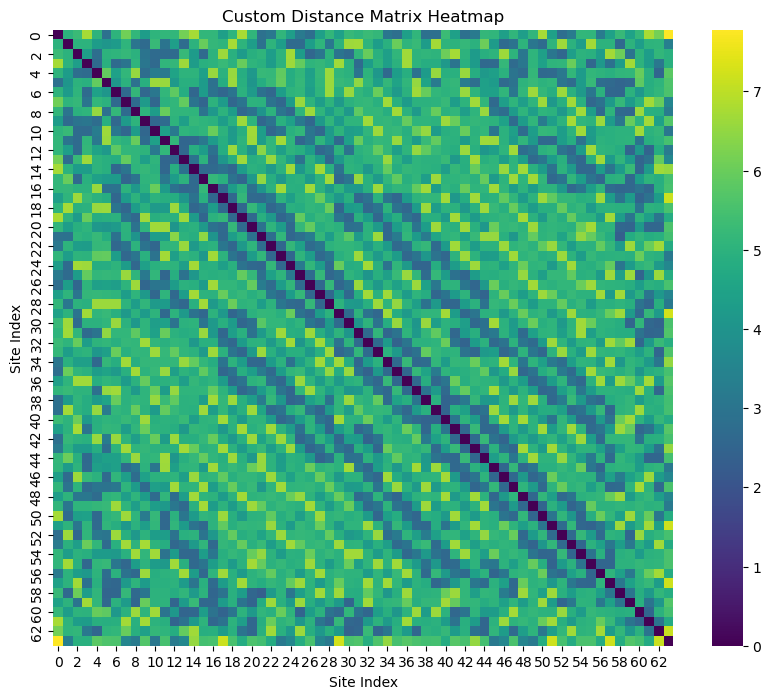

Sites with Highest Chemical Complexity:
[(PeriodicSite: W (-1.227, 2.132, 4.341) [0.002078, 0.2515, 0.4994], array([-1.22731987,  2.13240275,  4.3409668 ])), (PeriodicSite: Zr (2.467, 4.19, -0.8905) [0.4971, 0.4942, 0.2457], array([ 2.46749269,  4.19013878, -0.89047959])), (PeriodicSite: V (-1.18, 2.128, -0.79) [0.005885, 0.2509, 0.009978], array([-1.17968787,  2.12835832, -0.79002516]))]


In [43]:
contcar_file = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Gen_0-2/Perfect/supercell_gen0_comp10_struct1/CONTCAR'
# Example usage:
structure = Poscar.from_file(contcar_file).structure # Load your structure here

# Simulated Annealing Sampling
selected_sites = simulated_annealing_sampling(structure, num_points=5)
print("Selected Sites for Simulated Annealing Sampling:")
print([site.coords for site in selected_sites])

# Plot Distance Matrix
plot_distance_matrix(structure)

# Identify Highest Complexity Sites
top_sites = identify_highest_complexity_sites(structure)
print("Sites with Highest Chemical Complexity:")
print([(site, site.coords) for site in top_sites])


In [44]:
def identify_highest_complexity_sites(structure, top_n=3):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[-top_n:][::-1]
    return [sites[i] for i in top_indices]

# Example usage:
top_sites = identify_highest_complexity_sites(structure)
print("Sites with Highest Chemical Complexity:")
for site in top_sites:
    print(f"Index: {structure.index(site)}, Coordinates: {site.coords}")


Sites with Highest Chemical Complexity:
Index: 63, Coordinates: [-1.22731987  2.13240275  4.3409668 ]
Index: 0, Coordinates: [ 2.46749269  4.19013878 -0.89047959]
Index: 9, Coordinates: [-1.17968787  2.12835832 -0.79002516]


In [45]:
plot_structure_with_highlighted_sites(structure, top_sites)


In [49]:
import numpy as np
import random
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    selected_sites = []
    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)
        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            selected_sites.append(site)
            element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            for other_site in sites:
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[sites.index(other_site)] >= complexity_scores[index] * 0.9:
                        min_dist = dist
                        best_site = other_site
            if best_site:
                selected_sites.append(best_site)
                element_counts[str(best_site.species)] -= 1

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure,top_n=5)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [57]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    geometric_dist = site1.distance(site2)
    composition_dist = sum((site1.species.elements[i].X - site2.species.elements[i].X)**2 for i in range(len(site1.species.elements)))
    return geometric_dist + composition_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()

    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)

        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

            if not selected_neighbors.intersection(neighbors):
                selected_sites.append(site)
                selected_neighbors.update(neighbors)
                element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            best_index = None
            for other_index, other_site in enumerate(sites):
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                        neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                        if not selected_neighbors.intersection(neighbors):
                            min_dist = dist
                            best_site = other_site
                            best_index = other_index
            if best_site:
                selected_sites.append(best_site)
                selected_neighbors.update(neighbors)
                element_counts[str(best_site.species)] -= 1

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure, top_n=5, concentration_threshold=0.2)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [56]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    # Geometric distance
    geometric_dist = site1.distance(site2)
    
    # Chemical composition distance (difference in electronegativity)
    element1 = list(site1.species.elements)[0]
    element2 = list(site2.species.elements)[0]
    composition_dist = (element1.X - element2.X) ** 2
    
    # Debugging print statements
    #print(f"Geometric distance between {element1} and {element2}: {geometric_dist}")
    #print(f"Electronegativity difference squared: {composition_dist}")
    
    # Combined distance
    combined_dist = geometric_dist + composition_dist
    #print(f"Combined distance: {combined_dist}\n")
    
    return combined_dist

def identify_highest_complexity_sites(structure, top_n=3, initial_concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()
    
    concentration_threshold = initial_concentration_threshold
    while len(selected_sites) < top_n and concentration_threshold <= 1.0:
        for index in top_indices:
            if len(selected_sites) >= top_n:
                break
            site = sites[index]
            element = str(site.species)

            if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
                neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

                if not selected_neighbors.intersection(neighbors):
                    selected_sites.append(site)
                    selected_neighbors.update(neighbors)
                    element_counts[element] -= 1
            else:
                # Find a nearby site with comparable complexity and an element with more than 2 in the structure
                min_dist = float('inf')
                best_site = None
                best_index = None
                for other_index, other_site in enumerate(sites):
                    other_element = str(other_site.species)
                    if other_site not in selected_sites and element_counts[other_element] > 2:
                        dist = site.distance(other_site)
                        if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                            if not selected_neighbors.intersection(neighbors):
                                min_dist = dist
                                best_site = other_site
                                best_index = other_index
                if best_site:
                    selected_sites.append(best_site)
                    selected_neighbors.update(neighbors)
                    element_counts[str(best_site.species)] -= 1
        
        # If not enough sites found, relax the concentration threshold
        if len(selected_sites) < top_n:
            concentration_threshold += 0.1
    
    return selected_sites[:top_n]

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [61]:
import numpy as np
from pymatgen.core.structure import Structure
from pymatgen.core.sites import Site
import plotly.graph_objects as go
from collections import defaultdict
import itertools
from pymatgen.analysis.local_env import VoronoiNN
import random

# Define a list of colors for different elements
color_cycle = itertools.cycle([
    'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta'
])

def custom_distance(site1: Site, site2: Site) -> float:
    # Geometric distance
    geometric_dist = site1.distance(site2)
    
    # Chemical composition distance (difference in electronegativity)
    element1 = list(site1.species.elements)[0]
    element2 = list(site2.species.elements)[0]
    composition_dist = (element1.X - element2.X) ** 2
    
    # Debugging print statements
    #print(f"Geometric distance between {element1} and {element2}: {geometric_dist}")
    #print(f"Electronegativity difference squared: {composition_dist}")
    
    # Combined distance
    combined_dist = geometric_dist + composition_dist
    #print(f"Combined distance: {combined_dist}\n")
    
    return combined_dist

def identify_highest_complexity_sites(structure, top_n=3, concentration_threshold=0.5):
    sites = structure.sites
    complexity_scores = np.zeros(len(sites))
    
    for i, site1 in enumerate(sites):
        for site2 in sites:
            complexity_scores[i] += custom_distance(site1, site2)
    
    top_indices = complexity_scores.argsort()[::-1]
    
    element_counts = defaultdict(int)
    for site in sites:
        element_counts[str(site.species)] += 1
    
    vnn = VoronoiNN()
    selected_sites = []
    selected_neighbors = set()

    for index in top_indices:
        if len(selected_sites) >= top_n:
            break
        site = sites[index]
        element = str(site.species)

        if element_counts[element] > 2 or (element_counts[element] > 1 and element_counts[element] - 1 >= (1 - concentration_threshold) * element_counts[element]):
            neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))

            if not selected_neighbors.intersection(neighbors):
                selected_sites.append(site)
                selected_neighbors.update(neighbors)
                element_counts[element] -= 1
        else:
            # Find a nearby site with comparable complexity and an element with more than 2 in the structure
            min_dist = float('inf')
            best_site = None
            best_index = None
            for other_index, other_site in enumerate(sites):
                other_element = str(other_site.species)
                if other_site not in selected_sites and element_counts[other_element] > 2:
                    dist = site.distance(other_site)
                    if dist < min_dist and complexity_scores[other_index] >= complexity_scores[index] * 0.9:
                        neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, other_index))
                        if not selected_neighbors.intersection(neighbors):
                            min_dist = dist
                            best_site = other_site
                            best_index = other_index
            if best_site:
                selected_sites.append(best_site)
                selected_neighbors.update(neighbors)
                element_counts[str(best_site.species)] -= 1

    # If we don't have enough sites, add more based on distance
    while len(selected_sites) < top_n:
        for _ in range(top_n - len(selected_sites)):
            for index in range(len(sites)):
                if sites[index] not in selected_sites:
                    neighbors = set(n['site_index'] for n in vnn.get_nn_info(structure, index))
                    if not selected_neighbors.intersection(neighbors):
                        selected_sites.append(sites[index])
                        selected_neighbors.update(neighbors)
                        break

    return selected_sites

def plot_structure_with_highlighted_sites(structure, top_sites):
    fig = go.Figure()
    
    element_colors = defaultdict(lambda: next(color_cycle))
    
    # Plot all sites by element type
    for site in structure:
        element = str(site.species)
        color = element_colors[element]
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=5, color=color),
            name=element,
            legendgroup=element,
            showlegend=True
        ))

    # Highlight top sites
    for site in top_sites:
        element = str(site.species)
        fig.add_trace(go.Scatter3d(
            x=[site.x],
            y=[site.y],
            z=[site.z],
            mode='markers',
            marker=dict(size=10, color='red', symbol='diamond'),
            name=f'Highlighted {element}',
            legendgroup=f'Highlighted {element}',
            showlegend=True
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="Structure with Highlighted Sites"
    )

    fig.show()

import random
from pymatgen.core.structure import Structure

def randomly_pick_sites(structure, n):
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n sites from the structure
    random_sites = random.sample(structure.sites, n)
    return random_sites

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Randomly pick 5 sites from the supercell

# Print the coordinates of the randomly selected sites
#for site in random_sites:
    #print(f"Element: {site.species}, Coordinates: {site.coords}")

# Example usage:
# Load your structure
#structure = Structure.from_file("POSCAR")

# Identify the top sites with highest chemical complexity
top_sites = identify_highest_complexity_sites(structure, top_n=5, concentration_threshold=0.2)

# Plot the structure and highlight the top sites
plot_structure_with_highlighted_sites(structure, top_sites)


In [92]:
random_sites = randomly_pick_sites(structure, n=8)
plot_structure_with_highlighted_sites(structure, random_sites)

# Making NEB Jobs for Summit

In [34]:
import os
from ase.io import read, write
from ase.mep import DyNEB
from ase import Atoms
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter 
from ase.constraints import FixAtoms
from ase.io import Trajectory
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS, FIRE, BFGS, MDMin, QuasiNewton 
from ase.optimize.precon import PreconLBFGS
from pymatgen.core import Structure 
import sys
sys.path.append('../Modules')
from defect_maker import make_defects, return_x_neighbors
from vasp_misc import *
from NEB_Barrier import NEB_Barrier
import re

def load_and_sort_structure(entry):
    return Structure.from_dict(entry.structure.as_dict()).get_sorted_structure()
    
# create an entry from teh structure 
def create_entry(structure, data):
    return ComputedStructureEntry(structure, energy=0, data=data)

# create a list of entries from a list of structures
def create_entries(structures, data):
    return [create_entry(structure, dat) for structure, dat in zip(structures, data)]

# create a list of entries from a list of structures
def create_entries_from_files(structure_files, data):
    structures = [Structure.from_file(file) for file in structure_files]
    data = []
    for structure in structures:
        struc_data = {'generation' : 0, 'comp' : structure.composition.reduced_formula, 'struct' : 'Fixed_125'} 
        data.append(struc_data)
    return create_entries(structures, data)

def create_neb_files(base_directory, job_path, calculator, relax = True, num_images=5):

    # Iterate through each subdirectory in base_directory that starts with "supercell"
    num_failed = 0
    for subdir in os.listdir(base_directory):
        if subdir.startswith('structure'):

            print(subdir)
            subdir_path = os.path.join(base_directory, subdir)
            
            # Parse the subdirectory to identify all vac_site files
            files = os.listdir(subdir_path)
            vac_sites = {}

            for file in files:
                if file.startswith('structure_') and file.endswith('.vasp'):
                    parts = file.split('_')
                    vac_site = parts[6]
                    if vac_site not in vac_sites:
                        vac_sites[vac_site] = {'start': None, 'end': []}
                    if 'start' in file:
                        vac_sites[vac_site]['start'] = file
                    elif 'end' in file:
                        vac_sites[vac_site]['end'].append(file)

            # Process each vac_site
            for vac_site, files in vac_sites.items():
                start_file = files['start']
                end_files = files['end']
                
                if start_file is None or not end_files:
                    print(f"Skipping vac_site_{vac_site} in {subdir} due to missing start or end files.")
                    continue
                
                # Load the start structure
                start_structure = read(os.path.join(subdir_path, start_file))
                relaxed_start_structure = relaxer(start_structure, calculator=calculator)
                parts = subdir.split('_')
                comp = parts[3]
                for end_file in end_files:
                    # Load the end structure
                    end_structure = read(os.path.join(subdir_path, end_file))
                    relaxed_end_structure = relaxer(end_structure, calculator=calculator)
                    # Save the interpolated structures
                    neb_dir = os.path.join(job_path, subdir, f'neb_vac_site_{vac_site}_to_{end_file.split("_")[-1].split(".")[0]}')
                    os.makedirs(neb_dir, exist_ok=True)
                    # check if the results.json file exists
                    if os.path.exists(os.path.join(neb_dir, 'results.json')):
                        print(f"NEB interpolation for vac_site_{vac_site} in {subdir} already completed.")
                        continue
                    barrier = NEB_Barrier(start=relaxed_start_structure,
                                          end=relaxed_end_structure,
                                          vasp_energies=[0, 0],
                                          composition= comp,
                                          structure_number = int(subdir.split('_')[1]),
                                          defect_number = int(vac_site),
                                          direction = end_file.split("_")[-1].split(".")[0],
                                          root_path = neb_dir
                                          )
                    barrier.neb_run(num_images=5,
                                    potential = calculator,
                                    run_relax = False,
                                    neb_run = False,
                                    )
                    barrier.create_neb_vasp_job(num_kpts=4)
                    
    print(f"NEB interpolation completed with {num_failed} failures.")


def relaxer(atoms, calculator, fmax = 0.01, steps = 250, verbose=False, relax_cell=False, loginterval = 1):
    if isinstance(atoms, Structure):
        atoms = AseAtomsAdaptor.get_atoms(atoms)
    new_atoms = atoms.copy()
    new_atoms.calc = calculator 
    if relax_cell:
        print("Relaxing with cell relaxation")
        ucf = FrechetCellFilter(new_atoms)
        optimizer = PreconLBFGS(ucf, use_armijo=True)
        
    else:
        ucf = new_atoms 
        optimizer = PreconLBFGS(ucf, use_armijo=True)
    
    optimizer.run(fmax=fmax, steps=steps)
    return new_atoms

# create start structure from the entries
def find_target_atoms(structure, N, neighbor_distance=2, cutoff_distance=5):
    all_indices = list(range(len(structure)))
    random.shuffle(all_indices)
    target_atoms = []
    neighbor_sets = []

    print(f"All indices: {all_indices}")

    while all_indices and len(target_atoms) < N:
        index = all_indices.pop()
        neighbors = []
        for distance in range(1, neighbor_distance + 1):
            neighbors_distance, _ = return_x_neighbors(structure, target_atom_index=index, x_neighbor=distance, alat=structure.lattice.a)
            neighbors.extend(neighbors_distance)
        
        print(f"Index: {index}, Neighbors: {neighbors}")

        if not any(set(neighbors).intersection(neighbor_set) for neighbor_set in neighbor_sets):
            # Check if the distance to all existing target atoms is greater than the cutoff distance
            if all(structure.get_distance(index, target_atom) > cutoff_distance for target_atom in target_atoms):
                target_atoms.append(index)
                neighbor_sets.append(set(neighbors))
                print(f"Selected target atom index: {index}")

    #return target_atoms if len(target_atoms) == N else None
    return target_atoms
def randomly_pick_sites(structure, n, initial_cutoff=1.25, max_attempts=1000, reduction_factor=0.9):
    """
    Randomly selects a specified number of site indices from a given structure.

    Args:
        structure (Structure): The structure from which to randomly select sites.
        n (int): The number of sites to randomly select.
        initial_cutoff (float, optional): The initial cutoff distance for site selection. Defaults to 1.25.
        max_attempts (int, optional): The maximum number of attempts to make for site selection. Defaults to 1000.
        reduction_factor (float, optional): The reduction factor for the cutoff distance after each unsuccessful attempt. Defaults to 0.9.

    Returns:
        list: A list of indices of randomly selected sites from the structure.

    Raises:
        ValueError: If the number of sites to pick is greater than the number of sites in the structure.
    """
    # Ensure that n is not greater than the number of sites in the structure
    if n > len(structure.sites):
        raise ValueError("The number of sites to pick cannot be greater than the number of sites in the structure.")
    
    # Randomly select n site indices from the structure with iterative reduction in cutoff
    random_site_indices = []
    cutoff = initial_cutoff
    while len(random_site_indices) < n:
        attempts = 0
        while len(random_site_indices) < n and attempts < max_attempts:
            potential_index = random.randint(0, len(structure.sites) - 1)
            potential_site = structure.sites[potential_index]
            if all(np.linalg.norm(np.array(potential_site.coords) - np.array(structure.sites[idx].coords)) > cutoff * min(structure.lattice.abc) for idx in random_site_indices):
                random_site_indices.append(potential_index)
            attempts += 1
        
        if len(random_site_indices) < n:
            cutoff *= reduction_factor
            random_site_indices = []  # Reset and try again with a reduced cutoff
    
    return random_site_indices

# Function to select a random neighbor
def select_random_neighbor(structure, target_atom_index, x_neighbor):
    neighbors, _ = return_x_neighbors(structure, target_atom_index, x_neighbor, structure.lattice.a)
    if neighbors:
        return random.choice(neighbors)
    return None

# Function to create and save structures with vacancies
def create_and_save_structures(entries, num_sites, num_barriers_per_site, job_path, cutoff_distance=1.25):
    for k, entry in enumerate(entries):
        print(f"Processing entry {k+1}/{len(entries)}...")
        structure = load_and_sort_structure(entry)
        comp = str(structure.composition).replace(' ', '')
        #structure = entry[0]
        #print(structure)
        #target_atoms = find_target_atoms(structure, N, neighbor_distance, cutoff_distance)
        target_atoms = randomly_pick_sites(structure, num_sites, initial_cutoff= cutoff_distance)
        if not target_atoms:
            print(f"No suitable target atoms found for entry {k+1}. Skipping...")
            continue
        #print(f"Found target atoms for entry {k+1}: {target_atoms}")

        for t, target_atom_index in enumerate(target_atoms):
            print("On Target Atom: ", t, " out of ", len(target_atoms))
            start_structure, _ = make_defects(structure, target_atom_index, target_atom_index)
            #print("Start defect made")
            if start_structure is None:
                print(f"Failed to create start structure for entry {k+1}, target atom {target_atom_index}.")
                continue
            
            probabilities = [0.8, 0.2]
            selected_sites = []
            iteration = 0
            while len(selected_sites) < num_barriers_per_site and iteration < 500:
                iteration += 1
                x_neighbor = random.choices([1, 2], probabilities)[0]
                vac_site = select_random_neighbor(structure, target_atom_index, x_neighbor)
                if vac_site is not None and vac_site not in selected_sites:
                    selected_sites.append(vac_site)
                    _, end_structure = make_defects(structure, target_atom_index, vac_site)
                    if end_structure is None:
                        print(f"Failed to create end structure for entry {k+1}, target atom {target_atom_index}, vac_site {vac_site}.")
                        continue

                    # Create directory and filenames
                    directory = os.path.join(job_path, f"structure_{k}_comp_{comp}_vac_site_{target_atom_index}")
                    os.makedirs(directory, exist_ok=True)

                    start_filename = os.path.join(directory, f"structure_{k}_comp_{comp}_vac_site_{target_atom_index}_start.vasp")
                    end_filename = os.path.join(directory, f"structure_{k}_comp_{comp}_vac_site_{target_atom_index}_end_site_{vac_site}.vasp")

                    # Write the structures to POSCAR files
                    Poscar(start_structure).write_file(start_filename)
                    Poscar(end_structure).write_file(end_filename)



In [22]:
def create_computed_structure_entries(directory, target_gen=4):
    entries = []
    
    # Regular expression to extract gen value from filename
    gen_pattern = re.compile(r'_gen(\d+)_')
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.cif'):
            # Extract gen value from filename
            match = gen_pattern.search(filename)
            if match:
                gen_value = int(match.group(1))
                
                # Check if the gen value matches the target gen value
                if gen_value == target_gen:
                    file_path = os.path.join(directory, filename)
                    
                    # Read the structure from the CIF file
                    structure = Structure.from_file(file_path)
                    
                    # Create a ComputedStructureEntry
                    entry = ComputedStructureEntry(structure, 0.0)  # Replace 0.0 with the actual energy if available
                    entries.append(entry)
    
    return entries

In [23]:
# Example usage
directory = '/Users/myless/Packages/structure_maker/Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/Perfect'
entries = create_computed_structure_entries(directory, target_gen=4)

# Print the number of entries created
print(f"Number of ComputedStructureEntries created: {len(entries)}")

Number of ComputedStructureEntries created: 30


In [24]:
# now create the entries for the NEB calculations
output_dir = '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/Pre_NEB'
create_and_save_structures(entries, num_sites=5, num_barriers_per_site=5, job_path=output_dir)

Processing entry 1/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target Atom:  3  out of  5
On Target Atom:  4  out of  5
Processing entry 2/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target Atom:  3  out of  5
On Target Atom:  4  out of  5
Processing entry 3/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target Atom:  3  out of  5
On Target Atom:  4  out of  5
Processing entry 4/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target Atom:  3  out of  5
On Target Atom:  4  out of  5
Processing entry 5/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target Atom:  3  out of  5
On Target Atom:  4  out of  5
Processing entry 6/30...
On Target Atom:  0  out of  5
On Target Atom:  1  out of  5
On Target Atom:  2  out of  5
On Target 

In [35]:
from mace.calculators import MACECalculator

potential_path = '../Potentials/vcrtiwzr_vac_r6_e1_f25_s100_L2_stagetwo_compiled.model'
calculator = MACECalculator(model_paths=[potential_path], device='cpu', default_dtype='float64')
# now create NEB jobs from the created structures
base_directory = '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/Pre_NEB'
job_path = '../Visualization/Job_Structures/Pre_VASP/Fixed_VCrTiWZr_Summit/125-Atoms/Gen_4/NEB' 
create_neb_files(base_directory, job_path, calculator, relax = True, num_images=5)

structure_15_comp_Zr13Ti2V83Cr12W15_vac_site_106
PreconLBFGS:   0  23:07:25    -1147.877895       2.5107
PreconLBFGS:   1  23:07:30    -1149.976165       1.4926
PreconLBFGS:   2  23:07:32    -1151.343855       1.2307
PreconLBFGS:   3  23:07:33    -1152.342735       0.9799
PreconLBFGS:   4  23:07:35    -1153.016655       0.7882
PreconLBFGS:   5  23:07:36    -1153.467104       0.6245
PreconLBFGS:   6  23:07:37    -1153.750293       0.4895
PreconLBFGS:   7  23:07:39    -1153.919251       0.3864
PreconLBFGS:   8  23:07:40    -1154.015862       0.3115
PreconLBFGS:   9  23:07:41    -1154.071690       0.2634
PreconLBFGS:  10  23:07:42    -1154.107295       0.2378
PreconLBFGS:  11  23:07:43    -1154.133891       0.2139
PreconLBFGS:  12  23:07:45    -1154.156169       0.1816
PreconLBFGS:  13  23:07:46    -1154.176142       0.1566
PreconLBFGS:  14  23:07:48    -1154.194868       0.1517
PreconLBFGS:  15  23:07:49    -1154.212228       0.1552
PreconLBFGS:  16  23:07:50    -1154.227808       0.1531

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 2.319806e-02


PreconLBFGS:  44  23:08:25    -1154.528845       0.2324
PreconLBFGS:  45  23:08:26    -1154.541842       0.2344
PreconLBFGS:  46  23:08:27    -1154.579091       0.4782
PreconLBFGS:  47  23:08:29    -1154.596007       0.5894
PreconLBFGS:  48  23:08:30    -1154.613336       0.6945
PreconLBFGS:  49  23:08:31    -1154.630415       0.7826
PreconLBFGS:  50  23:08:33    -1154.646708       0.8453
PreconLBFGS:  51  23:08:34    -1154.661668       0.8786
PreconLBFGS:  52  23:08:35    -1154.675264       0.8921
PreconLBFGS:  53  23:08:37    -1154.688174       0.8936
PreconLBFGS:  54  23:08:38    -1154.700570       0.8751
PreconLBFGS:  55  23:08:39    -1154.714708       0.8681
PreconLBFGS:  56  23:08:41    -1154.729715       0.8576
PreconLBFGS:  57  23:08:42    -1154.745617       0.8327
PreconLBFGS:  58  23:08:43    -1154.764141       0.7956
PreconLBFGS:  59  23:08:44    -1154.786139       0.7406
PreconLBFGS:  60  23:08:45    -1154.814161       0.6805
PreconLBFGS:  61  23:08:47    -1154.848346      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 1.514143e-03


PreconLBFGS:  90  23:09:22    -1155.365685       0.0429
PreconLBFGS:  91  23:09:24    -1155.366485       0.0357
PreconLBFGS:  92  23:09:25    -1155.366871       0.0312
PreconLBFGS:  93  23:09:26    -1155.367326       0.0317
PreconLBFGS:  94  23:09:28    -1155.367708       0.0359
PreconLBFGS:  95  23:09:30    -1155.368413       0.0445
PreconLBFGS:  96  23:09:32    -1155.369727       0.0613
PreconLBFGS:  97  23:09:33    -1155.371177       0.0787
PreconLBFGS:  98  23:09:34    -1155.372424       0.0915
PreconLBFGS:  99  23:09:36    -1155.374154       0.1091
PreconLBFGS: 100  23:09:37    -1155.377453       0.1082
PreconLBFGS: 101  23:09:38    -1155.383510       0.1180
PreconLBFGS: 102  23:09:39    -1155.391178       0.1411
PreconLBFGS: 103  23:09:41    -1155.398158       0.1722
PreconLBFGS: 104  23:09:42    -1155.405351       0.2139


ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 8.037468e-02


PreconLBFGS: 105  23:09:42    -1155.405351       0.2139
PreconLBFGS: 106  23:09:43    -1155.417095       0.2084
PreconLBFGS: 107  23:09:45    -1155.431890       0.2173
PreconLBFGS: 108  23:09:46    -1155.443802       0.2170
PreconLBFGS: 109  23:09:47    -1155.454615       0.2049
PreconLBFGS: 110  23:09:48    -1155.465047       0.2263
PreconLBFGS: 111  23:09:50    -1155.475642       0.2400
PreconLBFGS: 112  23:09:51    -1155.486818       0.2334
PreconLBFGS: 113  23:09:52    -1155.498858       0.2297
PreconLBFGS: 114  23:09:53    -1155.511830       0.2550
PreconLBFGS: 115  23:09:55    -1155.525372       0.2635
PreconLBFGS: 116  23:09:56    -1155.538702       0.2493
PreconLBFGS: 117  23:09:57    -1155.550989       0.2136
PreconLBFGS: 118  23:09:59    -1155.566422       0.1537
PreconLBFGS: 119  23:10:00    -1155.575664       0.1585
PreconLBFGS: 120  23:10:04    -1155.583007       0.1605
PreconLBFGS: 121  23:10:06    -1155.590148       0.1545
PreconLBFGS: 122  23:10:08    -1155.598137      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 1.935580e-02


PreconLBFGS:  30  23:11:01    -1155.077593       0.1860
PreconLBFGS:  31  23:11:03    -1155.087894       0.2027
PreconLBFGS:  32  23:11:04    -1155.102772       0.2720
PreconLBFGS:  33  23:11:06    -1155.116131       0.3592
PreconLBFGS:  34  23:11:07    -1155.129713       0.4460
PreconLBFGS:  35  23:11:08    -1155.142922       0.5198
PreconLBFGS:  36  23:11:09    -1155.154835       0.5711
PreconLBFGS:  37  23:11:11    -1155.164656       0.5997
PreconLBFGS:  38  23:11:12    -1155.172175       0.6183
PreconLBFGS:  39  23:11:13    -1155.178938       0.6508
PreconLBFGS:  40  23:11:14    -1155.182655       0.6753
PreconLBFGS:  41  23:11:16    -1155.192252       0.7434
PreconLBFGS:  42  23:11:17    -1155.199437       0.7823
PreconLBFGS:  43  23:11:18    -1155.212576       0.8190
PreconLBFGS:  44  23:11:20    -1155.229824       0.8326
PreconLBFGS:  45  23:11:21    -1155.257110       0.7786
PreconLBFGS:  46  23:11:22    -1155.295834       0.6987
PreconLBFGS:  47  23:11:24    -1155.322734      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 6.604334e-03


PreconLBFGS:  57  23:13:12    -1154.751624       0.3916
PreconLBFGS:  58  23:13:13    -1154.767387       0.3915
PreconLBFGS:  59  23:13:14    -1154.797632       0.4046
PreconLBFGS:  60  23:13:15    -1154.851026       0.4555
PreconLBFGS:  61  23:13:17    -1154.898466       0.5176
PreconLBFGS:  62  23:13:18    -1154.943285       0.5823
PreconLBFGS:  63  23:13:19    -1154.986404       0.6399
PreconLBFGS:  64  23:13:20    -1155.027608       0.6764
PreconLBFGS:  65  23:13:22    -1155.066544       0.6910
PreconLBFGS:  66  23:13:23    -1155.103112       0.6930
PreconLBFGS:  67  23:13:24    -1155.137194       0.6818
PreconLBFGS:  68  23:13:25    -1155.168719       0.6547
PreconLBFGS:  69  23:13:27    -1155.197668       0.6130
PreconLBFGS:  70  23:13:28    -1155.224022       0.5579
PreconLBFGS:  71  23:13:30    -1155.247989       0.4920
PreconLBFGS:  72  23:13:31    -1155.270373       0.4236
PreconLBFGS:  73  23:13:33    -1155.292544       0.3540
PreconLBFGS:  74  23:13:34    -1155.316055      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 3.677834e-01


PreconLBFGS:  32  23:14:31    -1154.627711       0.2541
PreconLBFGS:  33  23:14:32    -1154.652764       0.2641
PreconLBFGS:  34  23:14:34    -1154.677971       0.3154
PreconLBFGS:  35  23:14:35    -1154.706642       0.4308
PreconLBFGS:  36  23:14:36    -1154.721517       0.4899
PreconLBFGS:  37  23:14:37    -1154.736957       0.5368
PreconLBFGS:  38  23:14:39    -1154.752539       0.5654
PreconLBFGS:  39  23:14:40    -1154.768064       0.5764
PreconLBFGS:  40  23:14:41    -1154.783444       0.5761
PreconLBFGS:  41  23:14:42    -1154.798656       0.5714
PreconLBFGS:  42  23:14:44    -1154.813698       0.5664
PreconLBFGS:  43  23:14:45    -1154.828551       0.5627
PreconLBFGS:  44  23:14:46    -1154.843218       0.5610
PreconLBFGS:  45  23:14:47    -1154.857773       0.5627
PreconLBFGS:  46  23:14:49    -1154.872323       0.5694
PreconLBFGS:  47  23:14:50    -1154.886966       0.5830
PreconLBFGS:  48  23:14:51    -1154.901781       0.6045
PreconLBFGS:  49  23:14:54    -1154.903134      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 3.935537e-02


PreconLBFGS:  50  23:14:54    -1154.903134       0.6270
PreconLBFGS:  51  23:14:55    -1154.905826       0.6240
PreconLBFGS:  52  23:14:56    -1154.911170       0.6202
PreconLBFGS:  53  23:14:57    -1154.921738       0.6148
PreconLBFGS:  54  23:14:58    -1154.942492       0.6079
PreconLBFGS:  55  23:15:00    -1154.982728       0.5978
PreconLBFGS:  56  23:15:01    -1155.020655       0.5808
PreconLBFGS:  57  23:15:02    -1155.055013       0.5600
PreconLBFGS:  58  23:15:03    -1155.086270       0.5260
PreconLBFGS:  59  23:15:04    -1155.114253       0.4708
PreconLBFGS:  60  23:15:06    -1155.138744       0.4012
PreconLBFGS:  61  23:15:07    -1155.159487       0.3202
PreconLBFGS:  62  23:15:09    -1155.176237       0.2300
PreconLBFGS:  63  23:15:11    -1155.188721       0.1304
PreconLBFGS:  64  23:15:12    -1155.199408       0.0717
PreconLBFGS:  65  23:15:14    -1155.201688       0.0613
PreconLBFGS:  66  23:15:15    -1155.205279       0.0371
PreconLBFGS:  67  23:15:16    -1155.207218      

ERROR:ase.utils.linesearcharmijo:Passed direction which is not downhill. Aborting...: 2.514765e-01


PreconLBFGS:  32  23:17:08    -1154.381784       0.2245
PreconLBFGS:  33  23:17:10    -1154.403047       0.2161
PreconLBFGS:  34  23:17:11    -1154.441039       0.2717
PreconLBFGS:  35  23:17:16    -1154.475380       0.3595
PreconLBFGS:  36  23:17:17    -1154.504657       0.4510
PreconLBFGS:  37  23:17:18    -1154.531963       0.5429
PreconLBFGS:  38  23:17:20    -1154.558533       0.6334
PreconLBFGS:  39  23:17:21    -1154.584698       0.7188
PreconLBFGS:  40  23:17:22    -1154.610482       0.7970
PreconLBFGS:  41  23:17:24    -1154.635894       0.8676
PreconLBFGS:  42  23:17:25    -1154.660881       0.9253
PreconLBFGS:  43  23:17:27    -1154.685220       0.9620
PreconLBFGS:  44  23:17:28    -1154.708834       0.9792
PreconLBFGS:  45  23:17:29    -1154.732001       0.9842
PreconLBFGS:  46  23:17:31    -1154.755112       0.9804
PreconLBFGS:  47  23:17:33    -1154.778541       0.9675
PreconLBFGS:  48  23:17:35    -1154.802791       0.9496
PreconLBFGS:  49  23:17:36    -1154.828315      

KeyboardInterrupt: 